## Attack 3: Make Stomach Similar to Head

In [1]:
import torch

print ('GPU Model: ', torch.cuda.get_device_name(torch.cuda.current_device()))

GPU Model:  GeForce GTX 1080


In [2]:
# !python setup.py

In [2]:
##### MODEL AND DATA LOADING
import torch
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import re

import os
import copy

from helpers import makedir, find_high_activation_crop
import model
import push
import train_and_test as tnt
import save
from log import create_logger
from preprocess import mean, std, preprocess_input_function, undo_preprocess_input_function

from settings import colab
from ct import ctx_noparamgrad_and_eval

In [3]:
from setup import setup_test_image

setup_test_image(idx=6801)

Image id: 6801.	IsTrain: 0
File name: 117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0042_797243.jpg


In [4]:
# specify the test image to be analyzed
if colab:
    test_image_dir = '/content/PPNet/local_analysis/Clay_colored_Sparrow_Class116_0042/' #'./local_analysis/Painted_Bunting_Class15_0081/'
else:
    test_image_dir = '/scratch/PPNet/local_analysis/Clay_colored_Sparrow_Class116_0042/' #'./local_analysis/Painted_Bunting_Class15_0081/'

test_image_name = 'Clay_Colored_Sparrow_0042_797243.jpg' #'Painted_Bunting_0081_15230.jpg'
test_image_label = 116 #15
makedir(test_image_dir)

# for leonhard
!cp /scratch/PPNet/datasets/cub200_cropped/test_cropped/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0042_797243.jpg /scratch/PPNet/local_analysis/Clay_colored_Sparrow_Class116_0042/

# for colab
# !cp /content/datasets/cub200_cropped/test_cropped/016.Painted_Bunting/Painted_Bunting_0004_16641.jpg /content/local_analysis/Painted_Bunting_Class15_0081/

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

test_image_path = os.path.join(test_image_dir, test_image_name)

# load the model
check_test_accu = False

if colab:
    load_model_dir = '/content/PPNet/saved_models/resnet18/003/' #'./saved_models/vgg19/003/'
else:
    load_model_dir = '/cluster/scratch/rarade/PPNet/saved_models/resnet18/003/' #'./saved_models/vgg19/003/'
load_model_name = '40push0.7437.pth' #'10_18push0.7822.pth'


model_base_architecture = load_model_dir.split('/')[2]
experiment_run = '/'.join(load_model_dir.split('/')[3:])

save_analysis_path = os.path.join(test_image_dir, model_base_architecture,
                                  experiment_run, load_model_name)
makedir(save_analysis_path)

log, logclose = create_logger(log_filename=os.path.join(save_analysis_path, 'local_analysis.log'))

load_model_path = os.path.join(load_model_dir, load_model_name)
epoch_number_str = re.search(r'\d+', load_model_name).group(0)
start_epoch_number = int(epoch_number_str)

log('load model from ' + load_model_path)
log('model base architecture: ' + model_base_architecture)
log('experiment run: ' + experiment_run)

ppnet = torch.load(load_model_path)
ppnet = ppnet.cuda()
ppnet_multi = torch.nn.DataParallel(ppnet)

img_size = ppnet_multi.module.img_size
prototype_shape = ppnet.prototype_shape
max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]

class_specific = True

normalize = transforms.Normalize(mean=mean, std=std)

load model from /cluster/scratch/rarade/PPNet/saved_models/resnet18/003/40push0.7437.pth
model base architecture: scratch
experiment run: rarade/PPNet/saved_models/resnet18/003/


In [6]:
# load the test data and check test accuracy
from settings import test_dir
if check_test_accu:
    test_batch_size = 100

    test_dataset = datasets.ImageFolder(
        test_dir,
        transforms.Compose([
            transforms.Resize(size=(img_size, img_size)),
            transforms.ToTensor(),
            normalize,
        ]))
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, shuffle=True,
        num_workers=4, pin_memory=False)
    log('test set size: {0}'.format(len(test_loader.dataset)))

    accu = tnt.test(model=ppnet_multi, dataloader=test_loader,
                    class_specific=class_specific, log=print)

##### SANITY CHECK
# confirm prototype class identity
load_img_dir = os.path.join(load_model_dir, 'img')

prototype_info = np.load(os.path.join(load_img_dir, 'epoch-'+epoch_number_str, 'bb'+epoch_number_str+'.npy'))
prototype_img_identity = prototype_info[:, -1]

log('Prototypes are chosen from ' + str(len(set(prototype_img_identity))) + ' number of classes.')
log('Their class identities are: ' + str(prototype_img_identity))

# confirm prototype connects most strongly to its own class
prototype_max_connection = torch.argmax(ppnet.last_layer.weight, dim=0)
prototype_max_connection = prototype_max_connection.cpu().numpy()
if np.sum(prototype_max_connection == prototype_img_identity) == ppnet.num_prototypes:
    log('All prototypes connect most strongly to their respective classes.')
else:
    log('WARNING: Not all prototypes connect most strongly to their respective classes.')

##### HELPER FUNCTIONS FOR PLOTTING
def save_preprocessed_img(fname, preprocessed_imgs, index=0):
    img_copy = copy.deepcopy(preprocessed_imgs[index:index+1])
    undo_preprocessed_img = undo_preprocess_input_function(img_copy)
    print('image index {0} in batch'.format(index))
    undo_preprocessed_img = undo_preprocessed_img[0]
    undo_preprocessed_img = undo_preprocessed_img.detach().cpu().numpy()
    undo_preprocessed_img = np.transpose(undo_preprocessed_img, [1,2,0])
    
    plt.imsave(fname, undo_preprocessed_img)
    return undo_preprocessed_img

def save_prototype(fname, epoch, index):
    p_img = plt.imread(os.path.join(load_img_dir, 'epoch-'+str(epoch), 'prototype-img'+str(index)+'.png'))
    #plt.axis('off')
    plt.imsave(fname, p_img)
    return p_img

def save_prototype_self_activation(fname, epoch, index):
    p_img = plt.imread(os.path.join(load_img_dir, 'epoch-'+str(epoch),
                                    'prototype-img-original_with_self_act'+str(index)+'.png'))
    #plt.axis('off')
    plt.imsave(fname, p_img)
    return p_img
    
def save_prototype_original_img_with_bbox(fname, epoch, index,
                                          bbox_height_start, bbox_height_end,
                                          bbox_width_start, bbox_width_end, color=(0, 255, 255)):
    p_img_bgr = cv2.imread(os.path.join(load_img_dir, 'epoch-'+str(epoch), 'prototype-img-original'+str(index)+'.png'))
    cv2.rectangle(p_img_bgr, (bbox_width_start, bbox_height_start), (bbox_width_end-1, bbox_height_end-1),
                  color, thickness=2)
    p_img_rgb = p_img_bgr[...,::-1]
    p_img_rgb = np.float32(p_img_rgb) / 255
    #plt.imshow(p_img_rgb)
    #plt.axis('off')
    plt.imsave(fname, p_img_rgb)
    return p_img_rgb
    
def imsave_with_bbox(fname, img_rgb, bbox_height_start, bbox_height_end,
                     bbox_width_start, bbox_width_end, color=(0, 255, 255)):
    img_bgr_uint8 = cv2.cvtColor(np.uint8(255*img_rgb), cv2.COLOR_RGB2BGR)
    cv2.rectangle(img_bgr_uint8, (bbox_width_start, bbox_height_start), (bbox_width_end-1, bbox_height_end-1),
                  color, thickness=2)
    img_rgb_uint8 = img_bgr_uint8[...,::-1]
    img_rgb_float = np.float32(img_rgb_uint8) / 255
    #plt.imshow(img_rgb_float)
    #plt.axis('off')
    plt.imsave(fname, img_rgb_float)
    return img_rgb_float

# load the test image and forward it through the network
preprocess = transforms.Compose([
   transforms.Resize((img_size,img_size)),
   transforms.ToTensor(),
   normalize
])

img_pil = Image.open(test_image_path)
img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))

Prototypes are chosen from 200 number of classes.
Their class identities are: [  0   0   0 ... 199 199 199]
All prototypes connect most strongly to their respective classes.


In [7]:
def torch2numpy(imgs, index=0):
    img_copy = copy.deepcopy(imgs[index:index+1])
    img_copy = img_copy[0]
    np_img = img_copy.detach().cpu().numpy()
    np_img = np.transpose(np_img, [1,2,0])
    return np_img

def plot_grid_on_image(img_variable, grid=7):
    img = torch2numpy(undo_preprocess_input_function(img_variable))
    assert img_size == img.shape[0] and img_size == img.shape[1], 'shapes must match.'
    step_x, step_y = img.shape[0]//grid, img.shape[1]//grid
    img[:,::step_y,:] = (0, 0, 0)
    img[::step_x,:,:] = (0, 0, 0)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.xticks(np.arange(0, img.shape[1], step_y), np.arange(0, grid, 1))
    plt.yticks(np.arange(0, img.shape[0], step_x), np.arange(0, grid, 1))
    plt.title('Test input image. With 7x7 grid.')
    plt.show()

def get_image_patch_position(loc, grid=7):
    xs, ys = [], []
    for l in loc:
        xs.append(l[1])
        ys.append(l[0])
    xmin, ymin = np.min(xs), np.min(ys)
    xmax, ymax = np.max(xs)+1, np.max(ys)+1
    xmin, ymin = max(xmin, 0), max(ymin, 0)
    xmax, ymax = min(xmax, grid-1), min(ymax, grid-1)
    xgrid = np.arange(0, img_size+1, img_size//grid)
    ygrid = np.arange(0, img_size+1, img_size//grid)
    return [ygrid[ymin], ygrid[ymax], xgrid[xmin], xgrid[xmax]]

def visualize_image_grid(preprocess_fn=None, images=None, titles=None, ncols=3):
    if titles:
        assert len(titles) == ncols
    N = np.ceil(len(images)/ncols)
    plt.figure(figsize=(3*ncols, 3*N))
    for i, image in enumerate(images):
        plt.subplot(N, ncols, i+1)
        if preprocess_fn:
            plt.imshow(preprocess_fn(image))
        else:
            plt.imshow(image)
        if i < ncols and titles:
            plt.title(titles[i])
        plt.axis('off')

def similarity_score(ppnet_multi, ppnet, preprocess_fn, x, y, pid=1, loc=None):
    assert loc != None, 'please provide the locations in feature map as a list of dict (x, y)'
    x = preprocess_fn(x.squeeze(0)).unsqueeze(0)
    y = torch.tensor([y])
    logits, min_distances = ppnet_multi(x)
    conv_output, distances = ppnet.push_forward(x)
    prototype_activations = ppnet.distance_2_similarity(min_distances)
    prototype_activation_patterns = ppnet.distance_2_similarity(distances)
    if ppnet.prototype_activation_function == 'linear':
        prototype_activations = prototype_activations + max_dist
        prototype_activation_patterns = prototype_activation_patterns + max_dist

    idx = 0
    tables = []
    for i in range(logits.size(0)):
        tables.append((torch.argmax(logits, dim=1)[i].item(), y[i].item()))
    
    sim = torch.zeros(len(loc)).cuda()
    for i, l in enumerate(loc):
        sim[i] = prototype_activation_patterns[idx][pid][l[0], l[1]]
    local_max_sim = torch.max(sim)
    global_max_sim = torch.max(prototype_activation_patterns[idx][pid])
    return torch.mean(sim), local_max_sim, global_max_sim


def pgd(x, mask, pid, loc, net_multi, net, preprocess_fn, attack_steps, attack_lr=2/255, attack_eps=8/255, 
        random_init=True, minimize=True, clip_min=0, clip_max=1):
    
    x_adv = x.clone()
    if random_init:
        x_adv = torch.clamp(x_adv + torch.empty_like(x).uniform_(-attack_eps, attack_eps), clip_min, clip_max) 

    for i in range(attack_steps):
        x_adv.requires_grad = True

        net_multi.zero_grad()
        sim_score, _, _ = similarity_score(net_multi, net, preprocess_fn, x_adv, test_image_label, pid, loc)

        loss = -sim_score
        loss.backward(retain_graph=True)
        grad = x_adv.grad.detach()
        grad = grad.sign()
        if minimize:
            x_adv = x_adv + attack_lr * grad * mask
        else:
            x_adv = x_adv - attack_lr * grad * mask

        x_adv = x + torch.clamp(x_adv - x, min=-attack_eps, max=attack_eps) * mask
        x_adv = x_adv.detach()
        x_adv = torch.clamp(x_adv, clip_min, clip_max)
    
    r_adv = x_adv - x
    sim_score, _, _ = similarity_score(net_multi, net, preprocess_fn, x_adv, test_image_label, pid, loc)
    return x_adv, r_adv, sim_score.item()

In [8]:
def local_analysis(img_variable, max_prototypes=10, idx=0, verbose=False, show_images=True):
    '''
    Perform local analysis.
    Arguments:
        img_variable (torch.Tensor): imput image to test on.
        max_prototypes (int): number of most similar prototypes to display (fefault: 10).
        idx (int): image id in the batch (default: 0)
    '''
    images_test = img_variable.cuda()
    labels_test = torch.tensor([test_image_label])

    logits, min_distances = ppnet_multi(images_test)
    conv_output, distances = ppnet.push_forward(images_test)
    prototype_activations = ppnet.distance_2_similarity(min_distances)
    prototype_activation_patterns = ppnet.distance_2_similarity(distances)
    if ppnet.prototype_activation_function == 'linear':
        prototype_activations = prototype_activations + max_dist
        prototype_activation_patterns = prototype_activation_patterns + max_dist

    tables = []
    for i in range(logits.size(0)):
        tables.append((torch.argmax(logits, dim=1)[i].item(), labels_test[i].item()))
    
    idx = idx
    predicted_cls = tables[idx][0]
    correct_cls = tables[idx][1]
    log('Predicted: ' + str(predicted_cls))
    log('Actual: ' + str(correct_cls))
    if predicted_cls == correct_cls:
        log('Prediction is correct.')
    else:
        log('Prediction is wrong.')
    
    original_img = save_preprocessed_img(os.path.join(save_analysis_path, 'original_img.png'),
                                         images_test, idx)

    ##### MOST ACTIVATED (NEAREST) 10 PROTOTYPES OF THIS IMAGE
    makedir(os.path.join(save_analysis_path, 'most_activated_prototypes'))

    log('Most activated 10 prototypes of this image:')
    log('--------------------------------------------------------------')
    
    array_act, sorted_indices_act = torch.sort(prototype_activations[idx])
    for i in range(1, max_prototypes+1):
        log('top {0} activated prototype for this image:'.format(i))
        p_img = save_prototype(os.path.join(save_analysis_path, 'most_activated_prototypes', 
                                            'top-%d_activated_prototype.png' % i), 
                               start_epoch_number, sorted_indices_act[-i].item())
        p_oimg_with_bbox = save_prototype_original_img_with_bbox(
            fname=os.path.join(save_analysis_path, 'most_activated_prototypes', 
                               'top-%d_activated_prototype_in_original_pimg.png' % i), 
            epoch=start_epoch_number,
            index=sorted_indices_act[-i].item(),
            bbox_height_start=prototype_info[sorted_indices_act[-i].item()][1],
            bbox_height_end=prototype_info[sorted_indices_act[-i].item()][2],
            bbox_width_start=prototype_info[sorted_indices_act[-i].item()][3],
            bbox_width_end=prototype_info[sorted_indices_act[-i].item()][4],
            color=(0, 255, 255))
        p_img_with_self_actn = save_prototype_self_activation(
            os.path.join(save_analysis_path, 'most_activated_prototypes', 
                         'top-%d_activated_prototype_self_act.png' % i), 
            start_epoch_number, sorted_indices_act[-i].item())
        
        log('prototype index: {0}'.format(sorted_indices_act[-i].item()))
        log('prototype class identity: {0}'.format(prototype_img_identity[sorted_indices_act[-i].item()]))
        if prototype_max_connection[sorted_indices_act[-i].item()] != prototype_img_identity[sorted_indices_act[-i].item()]:
            log('prototype connection identity: {0}'.format(prototype_max_connection[sorted_indices_act[-i].item()]))
        log('activation value (similarity score): {0}'.format(array_act[-i]))
        log('last layer connection with predicted class: {0}'.format(ppnet.last_layer.weight[predicted_cls][sorted_indices_act[-i].item()]))

        activation_pattern = prototype_activation_patterns[idx][sorted_indices_act[-i].item()].detach().cpu().numpy()
        upsampled_activation_pattern = cv2.resize(activation_pattern, dsize=(img_size, img_size),
                                                  interpolation=cv2.INTER_CUBIC)

        # show the most highly activated patch of the image by this prototype
        high_act_patch_indices = find_high_activation_crop(upsampled_activation_pattern)
        high_act_patch = original_img[high_act_patch_indices[0]:high_act_patch_indices[1],
                                      high_act_patch_indices[2]:high_act_patch_indices[3], :]
        if verbose:
            log('most highly activated patch of the chosen image by this prototype:')
        #plt.axis('off')
        plt.imsave(os.path.join(save_analysis_path, 'most_activated_prototypes',
                                'most_highly_activated_patch_by_top-%d_prototype.png' % i),
                   high_act_patch)
        if verbose:
            log('most highly activated patch by this prototype shown in the original image:')
        p_img_with_bbox = imsave_with_bbox(
            fname=os.path.join(save_analysis_path, 'most_activated_prototypes',
                               'most_highly_activated_patch_in_original_img_by_top-%d_prototype.png' % i), 
            img_rgb=original_img,
            bbox_height_start=high_act_patch_indices[0],
            bbox_height_end=high_act_patch_indices[1],
            bbox_width_start=high_act_patch_indices[2],
            bbox_width_end=high_act_patch_indices[3], color=(0, 255, 255))

        # show the image overlayed with prototype activation map
        rescaled_activation_pattern = upsampled_activation_pattern - np.amin(upsampled_activation_pattern)
        rescaled_activation_pattern = rescaled_activation_pattern / np.amax(rescaled_activation_pattern)
        heatmap = cv2.applyColorMap(np.uint8(255*rescaled_activation_pattern), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        heatmap = heatmap[...,::-1]
        overlayed_img = 0.5 * original_img + 0.3 * heatmap
        if verbose:
            log('prototype activation map of the chosen image:')
        #plt.axis('off')
        plt.imsave(os.path.join(save_analysis_path, 'most_activated_prototypes',
                                'prototype_activation_map_by_top-%d_prototype.png' % i),
                   overlayed_img)
        
        if show_images:
            visualize_image_grid(images=[p_oimg_with_bbox, p_img, p_img_with_bbox, overlayed_img], 
                                 titles=['Training Image from which \nprototype is taken', 'Prototype', 
                                         'Test Image + BBox', 'Test Image + Activation Map'], ncols=4)
            plt.tight_layout()
            plt.show()
        log('--------------------------------------------------------------')
    
    # logclose()
    return sorted_indices_act, prototype_activation_patterns

### Local Analysis: Original Image

Predicted: 116
Actual: 116
Prediction is correct.
image index 0 in batch
Most activated 10 prototypes of this image:
--------------------------------------------------------------
top 1 activated prototype for this image:
prototype index: 1167
prototype class identity: 116
activation value (similarity score): 3.2033920288085938
last layer connection with predicted class: 1.3560214042663574


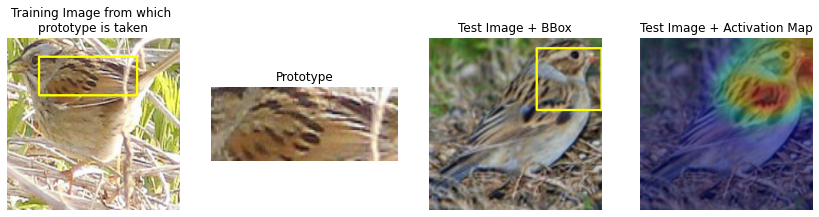

--------------------------------------------------------------
top 2 activated prototype for this image:
prototype index: 1166
prototype class identity: 116
activation value (similarity score): 3.062478542327881
last layer connection with predicted class: 1.3369938135147095


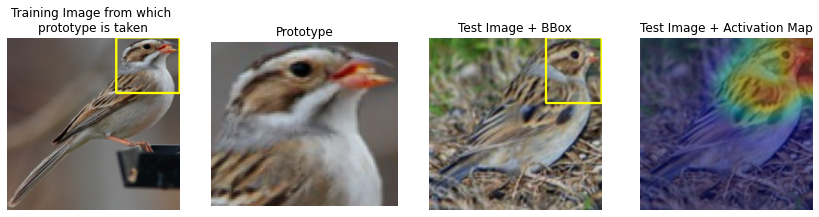

--------------------------------------------------------------
top 3 activated prototype for this image:
prototype index: 1160
prototype class identity: 116
activation value (similarity score): 2.8513882160186768
last layer connection with predicted class: 1.315294861793518


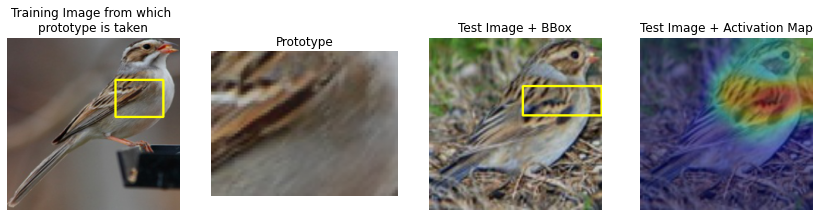

--------------------------------------------------------------
top 4 activated prototype for this image:
prototype index: 750
prototype class identity: 75
activation value (similarity score): 2.7912564277648926
last layer connection with predicted class: -1.7812149962992407e-05


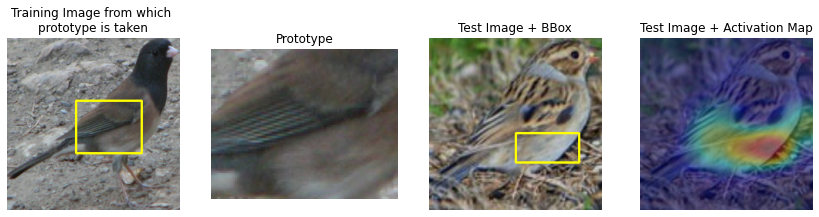

--------------------------------------------------------------
top 5 activated prototype for this image:
prototype index: 1165
prototype class identity: 116
activation value (similarity score): 2.6132278442382812
last layer connection with predicted class: 1.3647972345352173


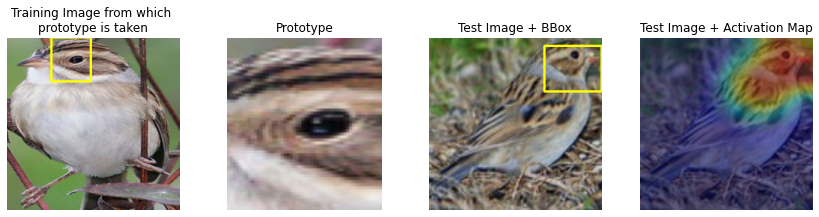

--------------------------------------------------------------
top 6 activated prototype for this image:
prototype index: 1163
prototype class identity: 116
activation value (similarity score): 2.6117095947265625
last layer connection with predicted class: 1.3694489002227783


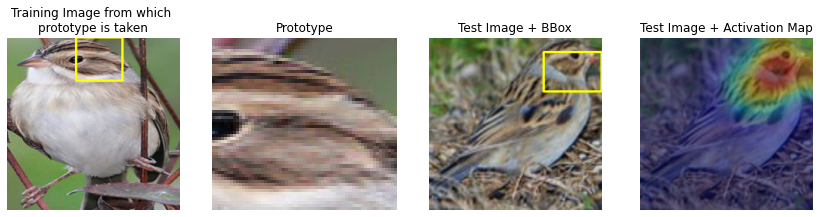

--------------------------------------------------------------
top 7 activated prototype for this image:
prototype index: 753
prototype class identity: 75
activation value (similarity score): 2.5451464653015137
last layer connection with predicted class: -4.2859010136453435e-06


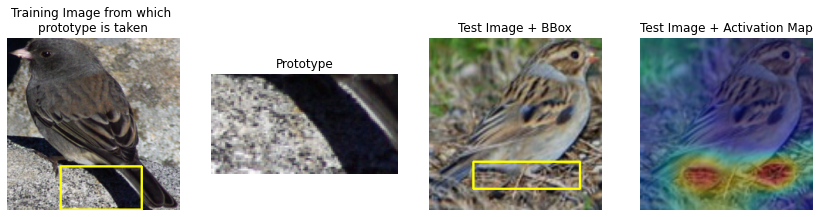

--------------------------------------------------------------
top 8 activated prototype for this image:
prototype index: 1161
prototype class identity: 116
activation value (similarity score): 2.521205186843872
last layer connection with predicted class: 1.3404350280761719


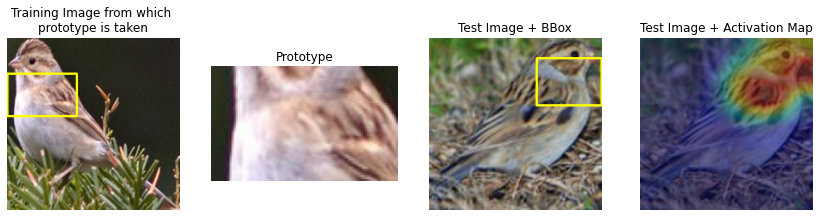

--------------------------------------------------------------
top 9 activated prototype for this image:
prototype index: 1123
prototype class identity: 112
activation value (similarity score): 2.5138893127441406
last layer connection with predicted class: -2.6985524527844973e-05


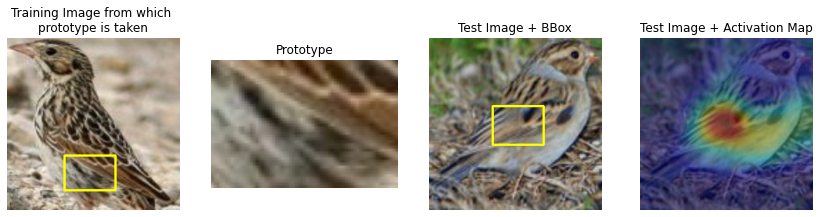

--------------------------------------------------------------
top 10 activated prototype for this image:
prototype index: 1122
prototype class identity: 112
activation value (similarity score): 2.457604169845581
last layer connection with predicted class: -1.046129546011798e-05


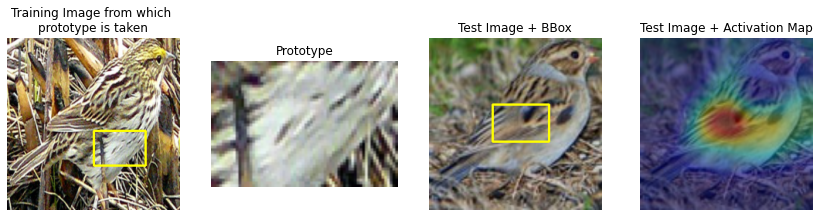

--------------------------------------------------------------


In [9]:
sorted_indices_act, prototype_activation_patterns = local_analysis(img_variable, show_images=True)

### Attack: Reduce Simlarity with a Prototype

In [10]:
def attack3(img_variable, loc, i=1, idx=0):
    '''
    Perform attack 2 (e.g. make head disappear).
    Arguments:
        img_variable (torch.Tensor): imput image to attack.
        loc ([(int, int)]): list of coordinates of the patch which we want to perturb.
        i (int): index of the prototype for which we want to maximize the similarity.
        idx (int): image id in the batch (default: 0)
    '''
    pid = i # index of the prototype for which we want to maximize the similarity.
    idx = idx # image index

    images_test = img_variable.cuda()
    labels_test = torch.tensor([test_image_label])
    
    original_img = save_preprocessed_img(os.path.join(save_analysis_path, 'original_img.png'), 
                                         images_test, idx)

    print ('Attacking prototype: {}'.format(pid))
    
    mask = np.zeros((img_size, img_size, 3))
    loc_img = get_image_patch_position(loc)
    mask[loc_img[0]:loc_img[1], loc_img[2]:loc_img[3], :] = 1
    mask = np.moveaxis(mask, 2, 0)
    mask = torch.from_numpy(mask)
    mask = (mask > 0).cuda()

    clip_min, clip_max = 0, 1
    toTensor = transforms.ToTensor()
    images_test_unprocessed = undo_preprocess_input_function(img_variable).cuda()

    with ctx_noparamgrad_and_eval(ppnet_multi):
        sim, lmax, gmax = similarity_score(ppnet_multi, ppnet, normalize, images_test_unprocessed, 
                                           test_image_label, pid, loc)
        print ('Similarity with prototype {} before attack is {:2f}.\tMax Similarity: {:2f}'.format(pid, lmax, gmax))
        images_perturbed, pert, score = pgd(images_test_unprocessed, mask, pid, loc, ppnet_multi, ppnet, 
                                            normalize, attack_steps=10, attack_lr=2/255, attack_eps=8/255, 
                                            clip_min=clip_min, clip_max=clip_max, minimize=False)

        sim, lmax, gmax = similarity_score(ppnet_multi, ppnet, normalize, images_perturbed, test_image_label, 
                                           pid, loc)
        print ('Similarity with prototype {} before attack is {:2f}.\tMax Similarity: {:2f}'.format(pid, lmax, gmax))
    
    visualize_image_grid(torch2numpy, images=[images_test_unprocessed, images_perturbed, pert*127+0.5], 
                         titles=['Original Image', 'Perturbed Image', 'Perturbation'])
    return images_perturbed, pert

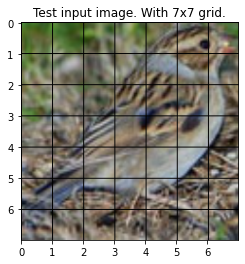

In [11]:
plot_grid_on_image(img_variable)

image index 0 in batch
Attacking prototype: 1165
Similarity with prototype 1165 before attack is 0.782304.	Max Similarity: 2.613228


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Similarity with prototype 1165 before attack is 4.357264.	Max Similarity: 4.357264


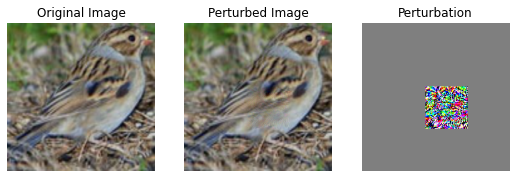

In [12]:
images_perturbed, _ = attack3(img_variable, loc=[(3, 3), (3, 4), (4, 3), (4, 4)], i=1165, idx=0)

### Local Analysis: Attacked Image

Predicted: 116
Actual: 116
Prediction is correct.
image index 0 in batch
Most activated 10 prototypes of this image:
--------------------------------------------------------------
top 1 activated prototype for this image:
prototype index: 1163
prototype class identity: 116
activation value (similarity score): 4.574413776397705
last layer connection with predicted class: 1.3694489002227783


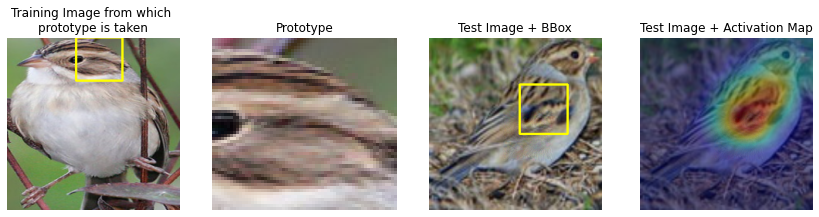

--------------------------------------------------------------
top 2 activated prototype for this image:
prototype index: 1165
prototype class identity: 116
activation value (similarity score): 4.357263565063477
last layer connection with predicted class: 1.3647972345352173


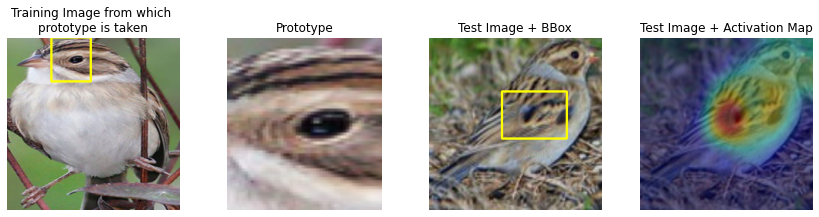

--------------------------------------------------------------
top 3 activated prototype for this image:
prototype index: 1166
prototype class identity: 116
activation value (similarity score): 4.1376776695251465
last layer connection with predicted class: 1.3369938135147095


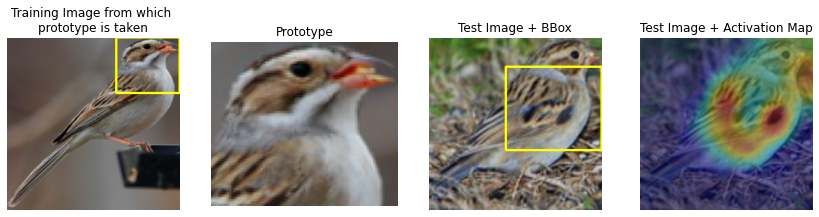

--------------------------------------------------------------
top 4 activated prototype for this image:
prototype index: 1167
prototype class identity: 116
activation value (similarity score): 4.11119270324707
last layer connection with predicted class: 1.3560214042663574


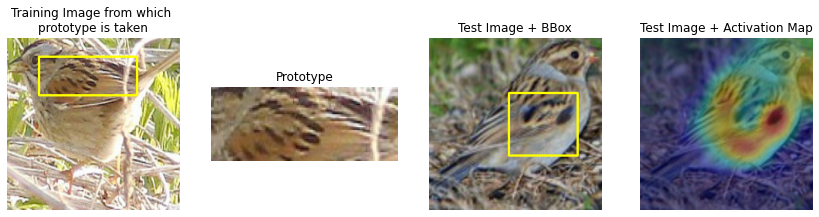

--------------------------------------------------------------
top 5 activated prototype for this image:
prototype index: 1161
prototype class identity: 116
activation value (similarity score): 3.5038721561431885
last layer connection with predicted class: 1.3404350280761719


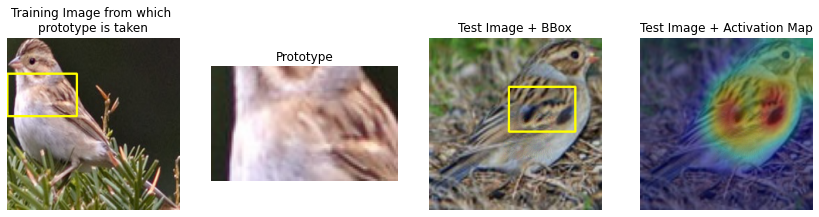

--------------------------------------------------------------
top 6 activated prototype for this image:
prototype index: 1160
prototype class identity: 116
activation value (similarity score): 2.564608573913574
last layer connection with predicted class: 1.315294861793518


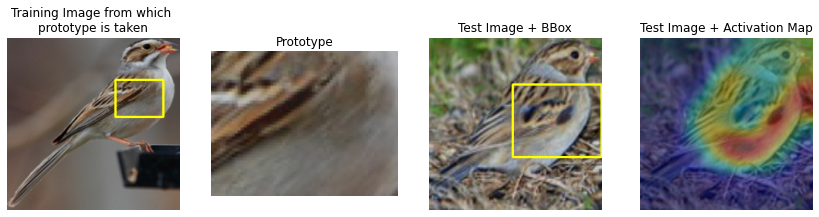

--------------------------------------------------------------
top 7 activated prototype for this image:
prototype index: 1140
prototype class identity: 114
activation value (similarity score): 2.337172508239746
last layer connection with predicted class: -3.5053280953434296e-06


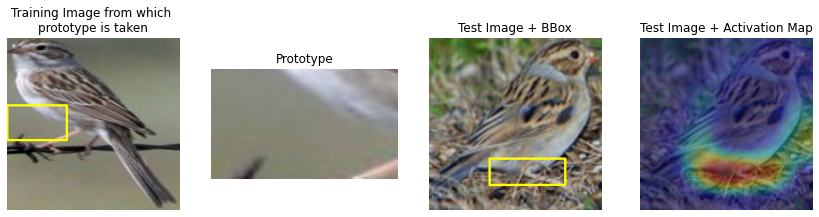

--------------------------------------------------------------
top 8 activated prototype for this image:
prototype index: 232
prototype class identity: 23
activation value (similarity score): 2.187530755996704
last layer connection with predicted class: -1.4966144590289332e-05


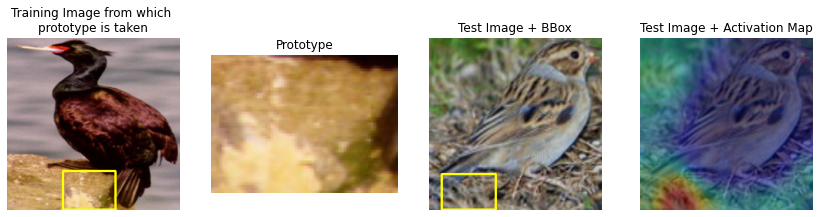

--------------------------------------------------------------
top 9 activated prototype for this image:
prototype index: 840
prototype class identity: 84
activation value (similarity score): 2.142970323562622
last layer connection with predicted class: -2.5879477107082494e-05


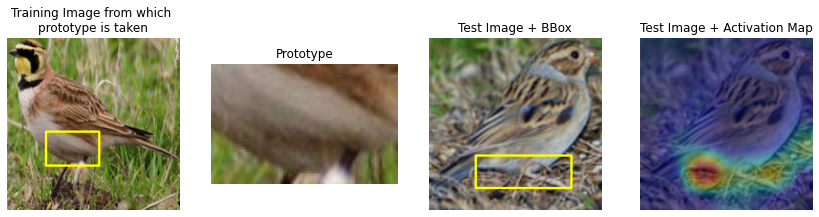

--------------------------------------------------------------
top 10 activated prototype for this image:
prototype index: 1164
prototype class identity: 116
activation value (similarity score): 2.028905153274536
last layer connection with predicted class: 1.3274327516555786


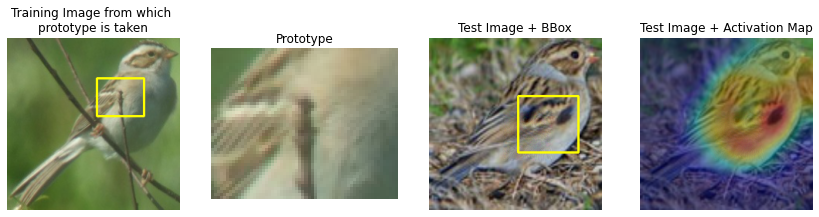

--------------------------------------------------------------


In [13]:
_, _ = local_analysis(normalize(images_perturbed.squeeze(0)).unsqueeze(0), show_images=True)